In [242]:
def ReadIntoDataframe(file):
    titles = []
    bodys = []
    dates = []
    columns = ["Title", "Body", "Date"]

    months = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
    days = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]

    try:
        with open(file, encoding='utf-8') as f:
            data = json.load(f)

            for year, months_data in data.items():
                for month, days_data in months_data.items():
                    for day, articles in days_data.items():
                        for el in articles:
                            titles.append(el["päis"].strip())
                            bodys.append(el["sisu"].strip())
                            dates.append(f"{year}-{month}-{day}")

    except UnicodeDecodeError:
        print("UnicodeDecodeError: File contains non-UTF-8 encoded data.")

    df = pd.DataFrame(list(zip(titles, bodys, dates)), columns=columns)
    return df

# Lae fail ja prindi välja unikaalsed kuupäevad
file_path = "ERR_Artiklid_Umbes_Kolm_Aastat.json"
df = ReadIntoDataframe(file_path)


In [243]:
# Lisage järgmised kaks rida enne, kui kasutate 'df["Date"].dt.year'
df['Date'] = pd.to_datetime(df['Date'])

# Jätkake oma olemasolevate printimiste väljatrükkimist
print(df['Title'].value_counts().head())
print(df['Body'].apply(len).describe())
print(df['Date'].value_counts().head(10))
print(df.columns)


Title
Aktuaalne kaamera kell 18:30    936
Viipekeelsed uudised            901
Aktuaalne kaamera kell 21:00    886
ERR-i teleuudised kell 9:00     510
Aktuaalne kaamera kell 17:00    467
Name: count, dtype: int64
count    109707.000000
mean       2109.666667
std        2904.843214
min           0.000000
25%         792.000000
50%        1402.000000
75%        2367.000000
max      140582.000000
Name: Body, dtype: float64
Date
2022-02-28    164
2021-05-20    162
2021-11-25    161
2021-09-02    161
2021-04-28    160
2022-03-01    160
2021-04-29    159
2021-10-26    159
2021-03-16    156
2021-05-27    156
Name: count, dtype: int64
Index(['Title', 'Body', 'Date'], dtype='object')


In [251]:
from estnltk import Text
import pandas as pd
from fuzzywuzzy import fuzz

# Sample DataFrame
# sample_df = df.sample(n=100, random_state=42)

texts = df['Body'].tolist()
dates = df['Date'].tolist()

# Extract only the news from the two months before the election
start_date = pd.to_datetime("2022-03-01")
end_date = pd.to_datetime("2022-03-05")
filtered_texts = [(text, date) for text, date in zip(texts, dates) if start_date <= date <= end_date]

# Initialize an empty list to store lemmatized named entities
lemmatized_entities = []

# Create a function for fuzzy string matching
def match_entities(entity_text, entity_list):
    for existing_entity, existing_lemma, _, _ in entity_list:
        if fuzz.ratio(existing_entity, entity_text) > 80:
            return existing_lemma
    return None

# Process each text and extract named entities
for text, date in filtered_texts:
    # Create an EstNLTK Text object
    estnltk_text = Text(text)

    # Perform named entity recognition
    estnltk_text.tag_layer('ner')

    # Extract named entities, lemmatize them, and add to the list
    for entity in estnltk_text.ner:
        if entity['nertag'] in {'PER', 'LOC', 'ORG'}:
            # Use entity.text instead of slicing
            lemmatized_text = ' '.join([word.lemma[0] for word in entity.morph_analysis])

            # Use fuzzy string matching to check if a similar entity already exists
            matched_lemma = match_entities(entity.text, lemmatized_entities)

            if matched_lemma:
                # If a similar entity is found, use the existing lemma
                lemmatized_entities.append((entity.text, matched_lemma, entity['nertag'], date))
            else:
                # If not, add the new entity to the list
                lemmatized_entities.append((entity.text, lemmatized_text, entity['nertag'], date))

# Convert the list of lemmatized entities to a pandas DataFrame
entities_df = pd.DataFrame(lemmatized_entities, columns=['Entity Text', 'Entity Lemma', 'Entity Type', 'Date'])


In [252]:

entity_counts = entities_df.groupby(['Entity Lemma', 'Entity Type', 'Date']).size().reset_index(name='Count')

# Sort the entities by count in descending order
sorted_entities = entity_counts.sort_values(by='Count', ascending=False)

# Display the top 10 most frequently mentioned entities for each type (ignoring the date)
for entity_type in sorted_entities['Entity Type'].unique():
    type_filtered_entities = sorted_entities[sorted_entities['Entity Type'] == entity_type]
    top_entities_type = type_filtered_entities.groupby('Entity Lemma')['Count'].sum().reset_index()
    top_entities_type = top_entities_type.sort_values(by='Count', ascending=False).head(10)
    print(f"Top 10 entities for {entity_type}:\n{top_entities_type[['Entity Lemma', 'Count']]}\n")

Top 10 entities for LOC:
    Entity Lemma  Count
540      Venemaa   1900
515      Ukraina   1501
89         Eesti    690
212        Kiiev    263
530    Valgevene    211
512          USA    198
106      Euroopa    176
457        Soome    102
379        Poola     80
428        Saksa     79

Top 10 entities for ORG:
      Entity Lemma  Count
547           NATO    202
355              I    159
184            ERR    115
197            ETV     61
1064           ÜRO     42
425    Keskerakond     42
262   Euroopa Liit     39
67           BBC .     32
440          Krahl     29
65             BBC     28

Top 10 entities for PER:
           Entity Lemma  Count
1588              Putin    192
20                Aesma     76
2092     Vladimir Putin     66
2151           Zelenski     59
1170            Luhansk     56
1020              Kirss     42
233               Biden     34
2104  Volodõmõr Zelensk     34
1890               Tamm     34
2181               palm     29



In [290]:
start_date = "2022-01-01"  # Alustame 2 kuud enne valimisi
end_date = "2022-03-06"    # Valimiste kuupäev


# Filtrime entities_df vastavalt kuupäevale ja entity type'ile "PER"
filtered_entities = sorted_entities[(sorted_entities['Date'] >= start_date) & (sorted_entities['Date'] <= end_date) & (sorted_entities['Entity Type'] == 'PER')]

# Grupeerime andmed 'Entity Text' järgi ja leime koguarvu
top_entities = filtered_entities.groupby('Entity Lemma')['Count'].sum().reset_index()

# Sorteerime andmed koguarvu järgi kahanevas järjekorras
top_entities = top_entities.sort_values(by='Count', ascending=False)

# Prindime top 5 enim mainitud isikunimed
top_25_entities_per = top_entities.head(60)
print(top_25_entities_per)


           Entity Lemma  Count
1588              Putin    192
20                Aesma     76
2092     Vladimir Putin     66
2151           Zelenski     59
1170            Luhansk     56
1020              Kirss     42
233               Biden     34
2104  Volodõmõr Zelensk     34
1890               Tamm     34
2181               palm     29
142                 Ans     28
1006              Kiiev     27
1297             Martin     27
1887            Tallinn     24
2026              Vaher     23
1564              Poola     23
1067           Krystyna     23
1267               Mark     21
633              Harkiv     20
52              Aleksei     20
1125     Leonhard Lapin     20
1064      Kristjan Tamm     20
91         Andrei Karhu     18
1323            Mazepin     18
2075              Vilde     18
551                Fred     17
1098              Lapin     17
1298       Martin Himma     16
1604               Raid     16
258             Brechti     16
1130             Lesser     15
1531    

In [289]:
# Filtrime entities_df vastavalt kuupäevale ja entity type'ile "PER"
filtered_entities = sorted_entities[(sorted_entities['Date'] >= start_date) & (sorted_entities['Date'] <= end_date) & (sorted_entities['Entity Type'] == 'ORG')]

# Grupeerime andmed 'Entity Text' järgi ja leime koguarvu
top_entities = filtered_entities.groupby('Entity Lemma')['Count'].sum().reset_index()

# Sorteerime andmed koguarvu järgi kahanevas järjekorras
top_entities = top_entities.sort_values(by='Count', ascending=False)

# Prindime top 5 enim mainitud isikunimed
top_25_entities_per = top_entities.head(50)
print(top_25_entities_per)


                        Entity Lemma  Count
547                             NATO    202
355                                I    159
184                              ERR    115
197                              ETV     61
1064                             ÜRO     42
425                      Keskerakond     42
262                     Euroopa Liit     39
67                             BBC .     32
440                            Krahl     29
65                               BBC     28
823               Tartu ülikool maks     28
682                          Reuters     27
806           Tallinn tehnikaülikool     26
373                         Interfax     22
951                             WNBA     21
804            Tallinn linnavalitsus     21
1032   rahvusvaheline kriminaalkohus     20
15                               AKG     19
19                               ATP     18
872            USA välisministeerium     18
279                             FIFA     18
1058                     vikerra

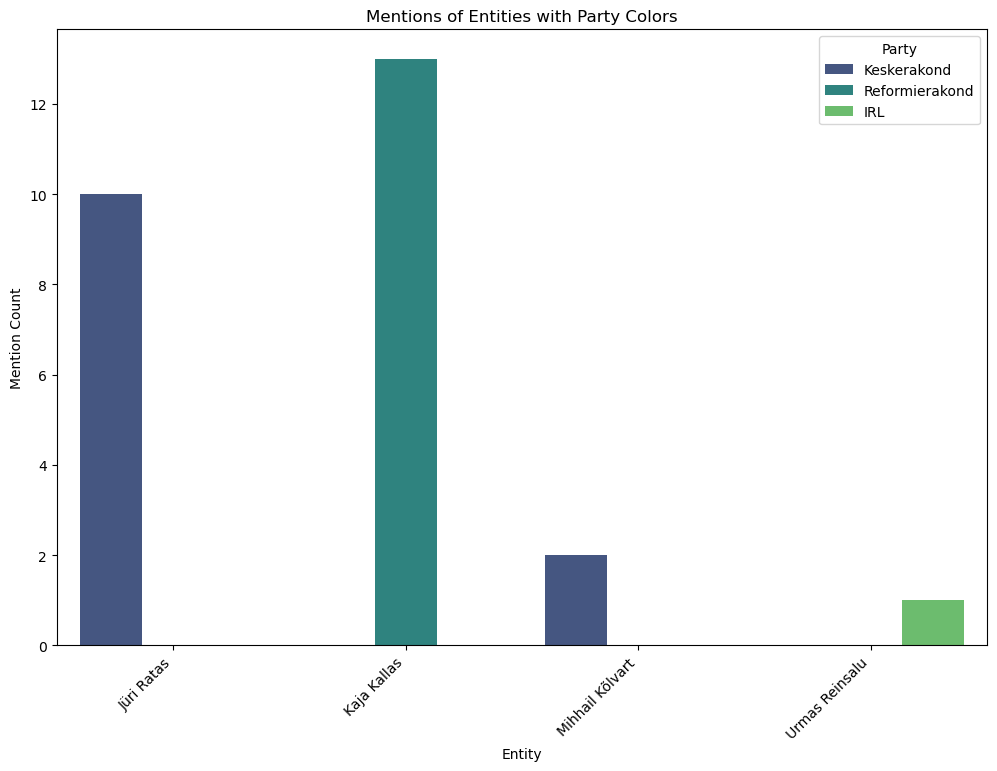

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mentions_with_color_and_party(names_and_parties, entities_df):
    # Filter entities_df for the desired names
    filtered_entities_df = entities_df[entities_df['Entity Lemma'].isin(names_and_parties.keys())].copy()

    # Add a new column 'Party' based on the mapping
    filtered_entities_df['Party'] = filtered_entities_df['Entity Lemma'].map(names_and_parties)

    # Plot the bar graph with different colors for each party
    plt.figure(figsize=(12, 8))
    sns.countplot(
        x='Entity Lemma',
        data=filtered_entities_df,
        hue='Party',
        palette='viridis',
    )
    plt.title('Mentions of Entities with Party Colors')
    plt.xlabel('Entity')
    plt.ylabel('Mention Count')
    plt.legend(title='Party')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Example usage with manually assigned parties
names_and_parties = {
    'Jüri Ratas': 'Keskerakond',
    'Kaja Kallas': 'Reformierakond',
    'Urmas Reinsalu': 'IRL',
    'Mihhail Kõlvart': 'Keskerakond',
}

plot_mentions_with_color_and_party(names_and_parties, entities_df)


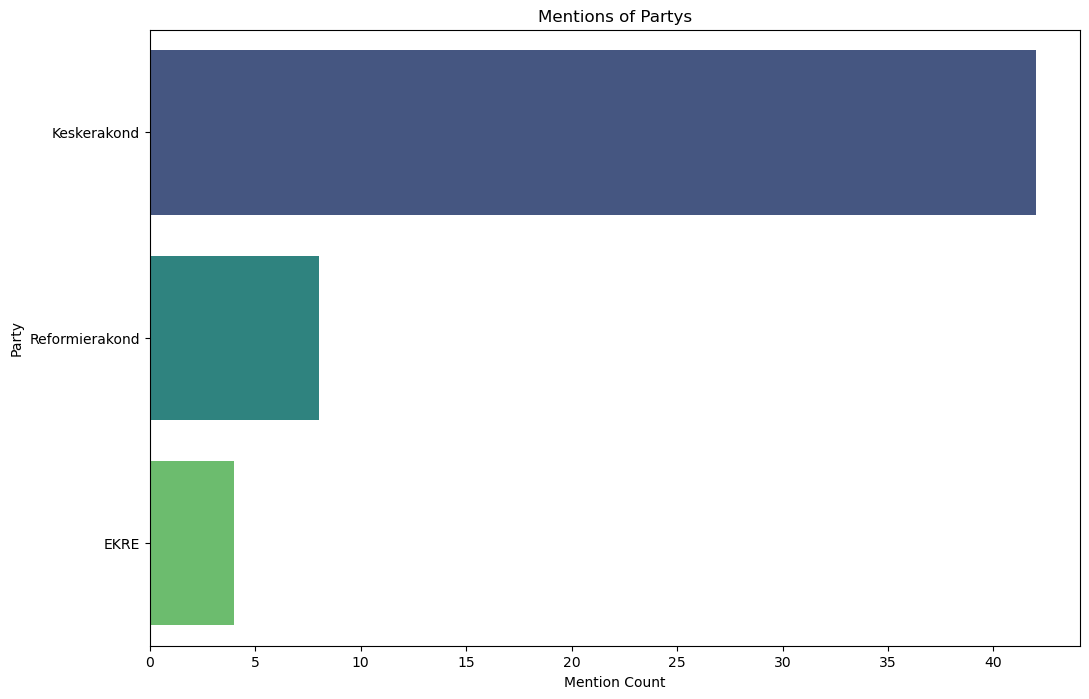

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mentions(names, entities_df):
    # Filter entities_df for the desired names
    filtered_entities_df = entities_df[entities_df['Entity Lemma'].isin(names)]

    # Count the occurrences of each entity
    entity_counts = filtered_entities_df['Entity Lemma'].value_counts()

    # Plot the bar graph
    plt.figure(figsize=(12, 8))
    sns.barplot(x=entity_counts.values, y=entity_counts.index, palette="viridis")
    plt.title('Mentions of Partys')
    plt.xlabel('Mention Count')
    plt.ylabel('Party')
    plt.show()

# Example usage with specific names
selected_names = ['Keskerakond', 'Reformierakond', 'EKRE']
plot_mentions(selected_names, entities_df)


Layer(name='ner', attributes=('nertag',), spans=SL[])
